# 1. Instalação de dependências

In [1]:
!pip install -q scikit-learn pandas joblib

# 2. Imports e configurações iniciais

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample


import joblib

# 3. Função de limpeza de texto

In [3]:
def clean_text(text):
  if not isinstance(text, str):
    return ""
  text = text.lower()
  text = re.sub(r"http\S+|www\S+|@\w+|#", " ", text)
  text = re.sub(r"[^a-záàâãéèêíïóôõöúçñ\s]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text

# 4. Normalização de colunas (fallback)

In [4]:
def normalize_columns(df):
  rename_map = {
    'texto': 'text', 'comentario': 'text', 'comentário': 'text', 'review': 'text',
    'sentimento': 'label', 'classe': 'label', 'rotulo': 'label', 'sentiment': 'label'
  }
  df = df.rename(columns={old: new for old, new in rename_map.items() if old in df.columns})


  if 'text' not in df.columns or 'label' not in df.columns:
      raise ValueError("CSV precisa conter colunas de texto e rótulo")


  return df[['text', 'label']]

# 5. Carregamento do dataset

In [5]:
from google.colab import files
import io

uploaded = files.upload()
filename = list(uploaded.keys())[0]

df = pd.read_csv(
    io.BytesIO(uploaded[filename]),
    sep=",",
    quotechar='"',
    doublequote=True,
    escapechar="\\",
    encoding="utf-8",
    engine="python",        # mais tolerante
    on_bad_lines="skip"     # ignora linhas problemáticas
)

df = normalize_columns(df)

print("Total de registros carregados:", len(df))
display(df.head())


Saving data.csv to data.csv
Total de registros carregados: 1969


,text,label
0,"Produto excelente, chegou rápido e bem embalad...",Positivo
1,"Chegou com defeito, tive que devolver. Péssimo.",Negativo
2,"Entrega no prazo, mas a embalagem veio amassada.",Neutro
3,"Amei demais! Cor perfeita, material ótimo.",Positivo
4,"Demorou 20 dias pra chegar, nunca mais compro ...",Negativo


# 6. Limpeza dos dados

In [6]:
df['text_clean'] = df['text'].apply(clean_text)
df = df[df['text_clean'] != ""]
df['label'] = df['label'].str.strip().str.capitalize()


print(df['label'].value_counts())

label
Positivo    813
Negativo    809
Neutro      346
Name: count, dtype: int64


# 7. Divisão treino / teste (ANTES do oversampling)

In [7]:
X = df['text_clean']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Oversampling manual apenas no treino

In [8]:
# Oversampling manual apenas no conjunto de treino

train_df = pd.DataFrame({
    'text': X_train,
    'label': y_train
})

majority_size = train_df['label'].value_counts().max()

balanced_parts = []

for label in train_df['label'].unique():
    subset = train_df[train_df['label'] == label]

    subset_upsampled = resample(
        subset,
        replace=True,
        n_samples=majority_size,
        random_state=42
    )

    balanced_parts.append(subset_upsampled)

train_balanced = pd.concat(balanced_parts).sample(frac=1, random_state=42)

print("Distribuição após oversampling (treino):")
print(train_balanced['label'].value_counts())


Distribuição após oversampling (treino):
label
Neutro      650
Positivo    650
Negativo    650
Name: count, dtype: int64


# 9. Vetorização TF-IDF

In [9]:
tfidf = TfidfVectorizer(
ngram_range=(1,2),
min_df=2,
max_df=0.9,
sublinear_tf=True
)


X_train_tfidf = tfidf.fit_transform(train_balanced['text'])
X_test_tfidf = tfidf.transform(X_test)


y_train_bal = train_balanced['label']

# 10. Treinamento dos modelos

In [10]:
lr_model = LogisticRegression(
max_iter=1000,
class_weight='balanced',
C=1.0,
random_state=42
)


svm_model = LinearSVC(
class_weight='balanced',
random_state=42
)


lr_model.fit(X_train_tfidf, y_train_bal)
svm_model.fit(X_train_tfidf, y_train_bal)

LinearSVC(class_weight='balanced', random_state=42)

# 11. Calcular e Expor palavras influentes

11.1 - Função para extrair palavras mais influentes (por frase)

In [19]:
def get_top_influential_words(
    text,
    model,
    vectorizer,
    top_n=5
):
    """
    Retorna as palavras mais influentes para a predição de uma frase.
    """
    # Vetor TF-IDF da frase
    text_vec = vectorizer.transform([text])

    # Classe prevista
    pred_class = model.predict(text_vec)[0]
    class_index = list(model.classes_).index(pred_class)

    # Coeficientes da classe prevista
    coefs = model.coef_[class_index]

    # Vocabulário
    feature_names = vectorizer.get_feature_names_out()

    # Converter vetor esparso em dicionário {palavra: peso}
    tfidf_scores = text_vec.toarray()[0]

    word_influence = {}

    for idx, score in enumerate(tfidf_scores):
        if score > 0:
            word = feature_names[idx]
            influence = score * coefs[idx]
            word_influence[word] = influence

    # Ordenar por influência (desc)
    top_words = sorted(
        word_influence.items(),
        key=lambda x: abs(x[1]),
        reverse=True
    )[:top_n]

    return [word for word, _ in top_words]


11.2 - Função final de predição (formato da API)

In [20]:
def predict_with_explanation(text):
    vec = tfidf.transform([text])

    pred = lr_model.predict(vec)[0]
    prob = lr_model.predict_proba(vec).max()

    top_words = get_top_influential_words(
        text=text,
        model=lr_model,
        vectorizer=tfidf,
        top_n=5
    )

    return {
        "previsao": pred,
        "probabilidade": round(float(prob), 2),
        "modelVersion": "LR-TFIDF-v1",
        "topWords": top_words
    }


11.3 - Teste prático

In [21]:
resultado = predict_with_explanation(
    "O atendimento foi ótimo e a entrega muito rápida"
)

resultado


{'previsao': 'Positivo',
 'probabilidade': 0.9,
 'modelVersion': 'LR-TFIDF-v1',
 'topWords': ['ótimo', 'rápida', 'entrega', 'atendimento', 'muito']}

11.4 - Função para extrair palavras com peso

In [22]:
def get_top_influential_words_with_weights(
    text,
    model,
    vectorizer,
    top_n=5
):
    """
    Retorna as palavras mais influentes na predição,
    incluindo o peso de influência de cada uma.
    """
    # Vetor TF-IDF da frase
    text_vec = vectorizer.transform([text])

    # Classe prevista
    pred_class = model.predict(text_vec)[0]
    class_index = list(model.classes_).index(pred_class)

    # Coeficientes da classe prevista
    coefs = model.coef_[class_index]

    # Vocabulário do TF-IDF
    feature_names = vectorizer.get_feature_names_out()

    # TF-IDF scores da frase
    tfidf_scores = text_vec.toarray()[0]

    word_influence = []

    for idx, score in enumerate(tfidf_scores):
        if score > 0:
            influence = score * coefs[idx]
            word_influence.append({
                "word": feature_names[idx],
                "weight": round(float(influence), 4)
            })

    # Ordenar por influência absoluta
    word_influence = sorted(
        word_influence,
        key=lambda x: abs(x["weight"]),
        reverse=True
    )[:top_n]

    return word_influence


11.5 - Função final de predição (formato API-ready)

In [16]:
def predict_with_explanation(text):
    vec = tfidf.transform([text])

    pred = lr_model.predict(vec)[0]
    prob = lr_model.predict_proba(vec).max()

    top_words = get_top_influential_words_with_weights(
        text=text,
        model=lr_model,
        vectorizer=tfidf,
        top_n=5
    )

    return {
        "previsao": pred,
        "probabilidade": round(float(prob), 2),
        "modelVersion": "LR-TFIDF-v1.1",
        "topWords": top_words
    }


11.6 - Saída esperada

In [23]:
{
  "previsao": "Positivo",
  "probabilidade": 0.88,
  "modelVersion": "LR-TFIDF-v1.1",
  "topWords": [
    {"word": "ótimo", "weight": 0.92},
    {"word": "atendimento", "weight": 0.63},
    {"word": "rápida", "weight": 0.58}
  ]
}



{'previsao': 'Positivo',
 'probabilidade': 0.88,
 'modelVersion': 'LR-TFIDF-v1.1',
 'topWords': [{'word': 'ótimo', 'weight': 0.92},
  {'word': 'atendimento', 'weight': 0.63},
  {'word': 'rápida', 'weight': 0.58}]}

# 12. Avaliação (métricas confiáveis)

In [24]:
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)


print('Acurácia LR:', accuracy_score(y_test, y_pred_lr))
print('Acurácia SVM:', accuracy_score(y_test, y_pred_svm))


print('\nRelatório Regressão Logística:\n')
print(classification_report(y_test, y_pred_lr, digits=4))


print('\nRelatório SVM Linear:\n')
print(classification_report(y_test, y_pred_svm, digits=4))

Acurácia LR: 0.9746192893401016
Acurácia SVM: 0.9593908629441624

Relatório Regressão Logística:

              precision    recall  f1-score   support

    Negativo     0.9697    0.9877    0.9786       162
      Neutro     0.9559    0.9420    0.9489        69
    Positivo     0.9876    0.9755    0.9815       163

    accuracy                         0.9746       394
   macro avg     0.9711    0.9684    0.9697       394
weighted avg     0.9747    0.9746    0.9746       394


Relatório SVM Linear:

              precision    recall  f1-score   support

    Negativo     0.9750    0.9630    0.9689       162
      Neutro     0.9143    0.9275    0.9209        69
    Positivo     0.9634    0.9693    0.9664       163

    accuracy                         0.9594       394
   macro avg     0.9509    0.9533    0.9521       394
weighted avg     0.9596    0.9594    0.9595       394



# 13 - Matrix de confusão

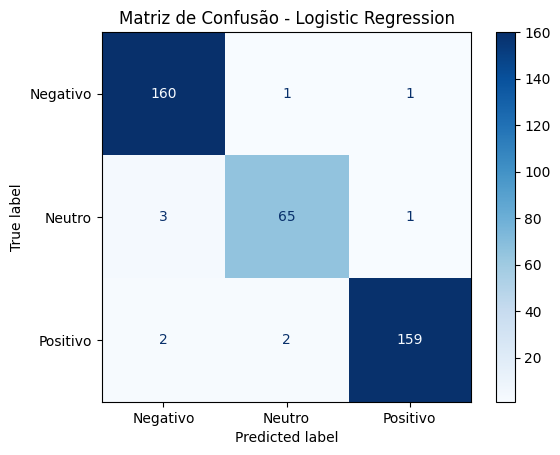

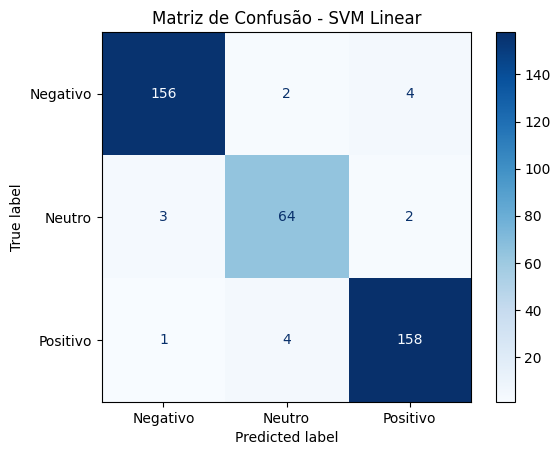

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== Matriz de Confusão - Logistic Regression =====
cm_lr = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=lr_model.classes_
)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=lr_model.classes_
)

disp_lr.plot(cmap='Blues')
plt.title('Matriz de Confusão - Logistic Regression')
plt.grid(False)
plt.show()


# ===== Matriz de Confusão - SVM Linear =====
cm_svm = confusion_matrix(
    y_test,
    y_pred_svm,
    labels=svm_model.classes_
)

disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=svm_model.classes_
)

disp_svm.plot(cmap='Blues')
plt.title('Matriz de Confusão - SVM Linear')
plt.grid(False)
plt.show()


# 14. Logistic Regression (normalizada)

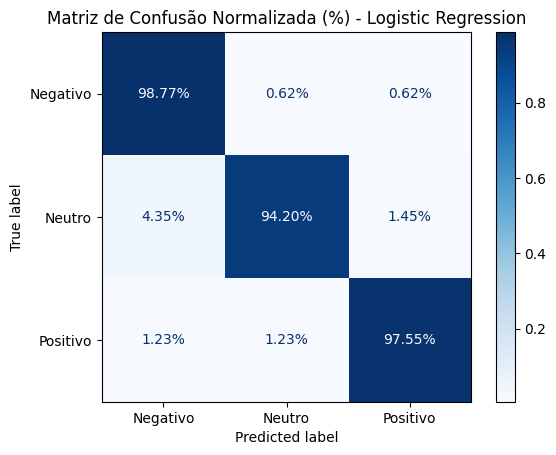

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz de Confusão Normalizada - Logistic Regression
cm_lr_norm = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=lr_model.classes_,
    normalize='true'
)

disp_lr_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr_norm,
    display_labels=lr_model.classes_
)

disp_lr_norm.plot(cmap='Blues', values_format='.2%')
plt.title('Matriz de Confusão Normalizada (%) - Logistic Regression')
plt.grid(False)
plt.show()


# 15. SVM Linear (normalizada)

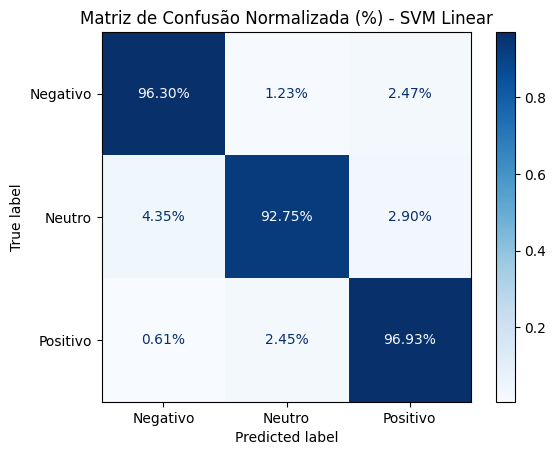

In [27]:
# Matriz de Confusão Normalizada - SVM Linear
cm_svm_norm = confusion_matrix(
    y_test,
    y_pred_svm,
    labels=svm_model.classes_,
    normalize='true'
)

disp_svm_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm_norm,
    display_labels=svm_model.classes_
)

disp_svm_norm.plot(cmap='Blues', values_format='.2%')
plt.title('Matriz de Confusão Normalizada (%) - SVM Linear')
plt.grid(False)
plt.show()


# 16. Validação Cruzada Estratificada (confiabilidade)

In [28]:
from sklearn.model_selection import StratifiedKFold, cross_val_score


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


lr_cv_scores = cross_val_score(
lr_model,
X_train_tfidf,
y_train_bal,
cv=skf,
scoring='f1_macro'
)


svm_cv_scores = cross_val_score(
svm_model,
X_train_tfidf,
y_train_bal,
cv=skf,
scoring='f1_macro'
)


print('LR - F1 Macro (CV):', lr_cv_scores)
print('LR - Média F1:', lr_cv_scores.mean())


print('SVM - F1 Macro (CV):', svm_cv_scores)
print('SVM - Média F1:', svm_cv_scores.mean())

LR - F1 Macro (CV): [0.98459444 0.98974276 0.99230739 0.98975338 0.99230746]
LR - Média F1: 0.9897410853756231
SVM - F1 Macro (CV): [0.98459444 0.98458443 0.99230739 0.98719891 0.99743586]
SVM - Média F1: 0.9892242048198007


# 17. Comparação gráfica: LR vs SVM

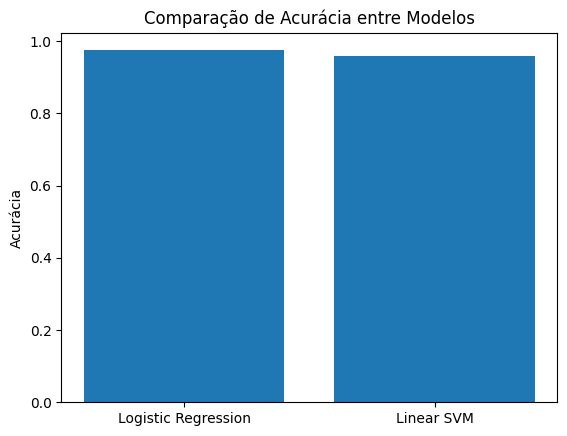

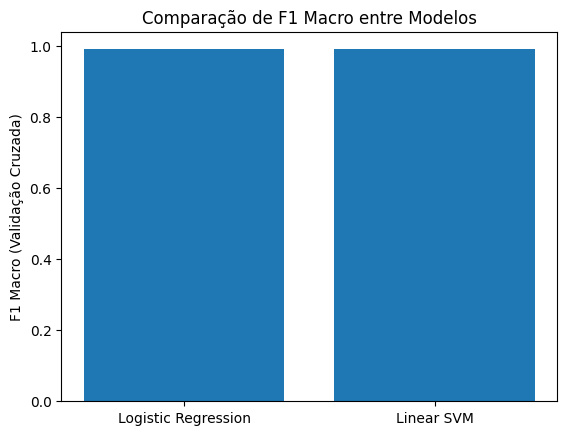

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Recalcular predições (segurança contra erro de execução fora de ordem)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Recalcular acurácia
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)

models = ['Logistic Regression', 'Linear SVM']
accuracy_scores = [acc_lr, acc_svm]
f1_scores = [lr_cv_scores.mean(), svm_cv_scores.mean()]

# Gráfico de Acurácia
plt.figure()
plt.bar(models, accuracy_scores)
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.show()

# Gráfico de F1 Macro (Validação Cruzada)
plt.figure()
plt.bar(models, f1_scores)
plt.ylabel('F1 Macro (Validação Cruzada)')
plt.title('Comparação de F1 Macro entre Modelos')
plt.show()


# 18. Check Point

In [30]:
[x for x in globals().keys() if 'log' in x.lower() or 'lr' in x.lower()]


['LogisticRegression',
 'lr_model',
 'y_pred_lr',
 'cm_lr',
 'disp_lr',
 'cm_lr_norm',
 'disp_lr_norm',
 'lr_cv_scores',
 'acc_lr']

In [ ]:
assert 'tfidf' in globals(), "TF-IDF não foi carregado"
assert 'lr_model' in globals(), "Modelo Logistic Regression (lr_model) não foi treinado"
assert 'svm_model' in globals(), "Modelo SVM não foi treinado"

print("Tudo pronto para testes ✅")



Tudo pronto para testes ✅


## 19. Teste prático – Logistic Regression e SVM

In [31]:
# Frases novas para teste rápido
novas_frases = [
    "O produto é incrível, chegou super rápido!",
    "Péssima qualidade, quebrou no primeiro dia.",
    "Chegou ok, nada demais."
]

# Vetorização (usa o mesmo TF-IDF já treinado)
novas_frases_vec = tfidf.transform(novas_frases)

# Predições
pred_lr = lr_model.predict(novas_frases_vec)
pred_svm = svm_model.predict(novas_frases_vec)

print("Teste prático - Logistic Regression:")
for frase, pred in zip(novas_frases, pred_lr):
    print(f"Frase: '{frase}' => Predição: {pred}")

print("\nTeste prático - SVM Linear:")
for frase, pred in zip(novas_frases, pred_svm):
    print(f"Frase: '{frase}' => Predição: {pred}")


Teste prático - Logistic Regression:
Frase: 'O produto é incrível, chegou super rápido!' => Predição: Positivo
Frase: 'Péssima qualidade, quebrou no primeiro dia.' => Predição: Negativo
Frase: 'Chegou ok, nada demais.' => Predição: Neutro

Teste prático - SVM Linear:
Frase: 'O produto é incrível, chegou super rápido!' => Predição: Positivo
Frase: 'Péssima qualidade, quebrou no primeiro dia.' => Predição: Negativo
Frase: 'Chegou ok, nada demais.' => Predição: Neutro


#20. Segundo teste (Logistic Regression)

In [32]:
# Segundo conjunto de frases para análise detalhada
frases_teste = [
    "O suporte foi muito atencioso e resolveu tudo rapidamente.",
    "Não gostei. A cor é muito diferente da foto do anúncio.",
    "O produto é honesto, cumpre o que promete sem luxos.",
    "A entrega atrasou demais e a caixa chegou amassada.",
    "Simplesmente fantástico, superou todas as minhas expectativas!",
    "Veio quebrado, quero meu dinheiro de volta imediatamente.",
    "Manual de instruções muito confuso, não consegui montar.",
    "Atendeu à necessidade, nada espetacular.",
    "Muito bem embalado e com acabamento premium.",
    "Este produto é ótimo"
]

# Vetorização com o TF-IDF já treinado
frases_teste_vec = tfidf.transform(frases_teste)

# Predição e probabilidade (Logistic Regression)
predicoes = lr_model.predict(frases_teste_vec)
probs = lr_model.predict_proba(frases_teste_vec)

df_teste_resultado = pd.DataFrame({
    'Texto': frases_teste,
    'Predição': predicoes,
    'Confiança (Prob. Máx)': probs.max(axis=1)
})

display(df_teste_resultado)


,Texto,Predição,Confiança (Prob. Máx)
0,O suporte foi muito atencioso e resolveu tudo ...,Positivo,0.527902
1,Não gostei. A cor é muito diferente da foto do...,Negativo,0.742042
2,"O produto é honesto, cumpre o que promete sem ...",Neutro,0.923144
3,A entrega atrasou demais e a caixa chegou amas...,Positivo,0.495379
4,"Simplesmente fantástico, superou todas as minh...",Positivo,0.835418
5,"Veio quebrado, quero meu dinheiro de volta ime...",Negativo,0.892929
6,"Manual de instruções muito confuso, não conseg...",Negativo,0.524544
7,"Atendeu à necessidade, nada espetacular.",Neutro,0.529654
8,Muito bem embalado e com acabamento premium.,Positivo,0.541279
9,Este produto é ótimo,Positivo,0.526928


# 21. Salvando o modelo

In [33]:
joblib.dump(lr_model, 'modelo_lr_sentimentos.pkl')
joblib.dump(svm_model, 'modelo_svm_sentimentos.pkl')
joblib.dump(tfidf, 'tfidf.pkl')

['tfidf.pkl']